In [96]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import time

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 16, 10

RANDOM_SEED = 42

TRAFFIC_DIRECTION = 'received'

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [106]:
import requests
import json

# Fetch data from netdata
vim_endpoint = "vimdemo1.cs.upb.de"
chart_id = "cgroup_qemu_qemu_127_instance_0000007f.net_tap0c32c278_4e"
# 7 days = 604800
avg_sec = 604800
group_time = 10
_c_name = chart_id.split(".")[1]

# http://vimdemo1.cs.upb.de:19999/api/v1/data?chart=cgroup_qemu_qemu_127_instance_0000007f.net_tap0c32c278_4e&gtime=60
_chart_avg_url = "http://{host}:19999/api/v1/data?chart={chart_id}&format=json&after=-{last_sec_avg}&gtime={gtime}"

r = requests.get(_chart_avg_url.format(host=vim_endpoint, chart_id=chart_id, 
                                           last_sec_avg=avg_sec, gtime=group_time), verify=False)

_instance_metrics = {}

if r.status_code == requests.codes.ok:
    _result_json = json.loads(r.text)
    if "net" in _c_name:
        if "packets" in _c_name:
            _instance_metrics["packets"] = _result_json
        else:
            _instance_metrics["net"] = _result_json
    else:
        _instance_metrics[_c_name] = _result_json

# _result_json


In [114]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))

train = pd.DataFrame(_result_json['data'], columns=_result_json['labels'])

train = train.set_index("time")



traffic_training_complete = train
traffic_training_processed_complete = traffic_training_complete[[TRAFFIC_DIRECTION]]
traffic_training_scaled_complete = scaler.fit_transform(traffic_training_processed_complete)

train.head()

,received,sent
time,,
1584196320,11.319646,0.0
1584196310,5.760112,0.0
1584196300,9.598470,0.0
1584196290,13.456375,0.0
1584196280,5.633873,0.0


In [108]:
# plt.plot(time, sin, label='sine (with noise)');
# plt.legend();
traffic_training_scaled_complete

array([[0.07193525],
       [0.03660495],
       [0.06099734],
       ...,
       [0.10177991],
       [0.12765131],
       [0.0917628 ]])

# Data Preprocessing

In [100]:
df = pd.DataFrame(traffic_training_scaled_complete, columns=[TRAFFIC_DIRECTION])
df.head(5)

df_original = pd.DataFrame(traffic_training_processed_complete, columns=[TRAFFIC_DIRECTION])
df_original.head(5)

,received
time,
1584195820,5.848400
1584195810,22.016167
1584195800,11.248383
1584195790,2.488161
1584195780,7.568000


In [101]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size

train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

train_original, test_original = df_original.iloc[0:train_size], df_original.iloc[train_size:len(df_original)]

test.head()

8613 2154


,received
8613,0.092421
8614,0.093083
8615,0.052418
8616,0.028013
8617,0.051297


In [102]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [103]:
time_steps = 5

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train[TRAFFIC_DIRECTION], time_steps)
X_test, y_test = create_dataset(test, test[TRAFFIC_DIRECTION], time_steps)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(8608, 5, 1) (8608,)
(2149, 5, 1) (2149,)


# Modeling

In [104]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

model = keras.Sequential()
# model.add(keras.layers.LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(keras.layers.Dense(1))

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

# model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(0.001))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

## Training

In [105]:
start_time = time.time()
EPOCHS = 5
BATCH_SIZE = 32

history = model.fit(
    X_train, y_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.1, 
    verbose=1
)

print("Time taken: ", time.time()-start_time)


Train on 7747 samples, validate on 861 samples
Epoch 1/5
7747/7747 [==============================] - 24s 3ms/sample - loss: 0.0015 - val_loss: 0.0023
Epoch 2/5
7747/7747 [==============================] - 16s 2ms/sample - loss: 0.0014 - val_loss: 0.0023
Epoch 3/5
7747/7747 [==============================] - 11s 1ms/sample - loss: 0.0014 - val_loss: 0.0023
Epoch 4/5
7747/7747 [==============================] - 13s 2ms/sample - loss: 0.0014 - val_loss: 0.0023
Epoch 5/5
7747/7747 [==============================] - 11s 1ms/sample - loss: 0.0014 - val_loss: 0.0023
Time taken:  75.71099281311035


## Evaluation

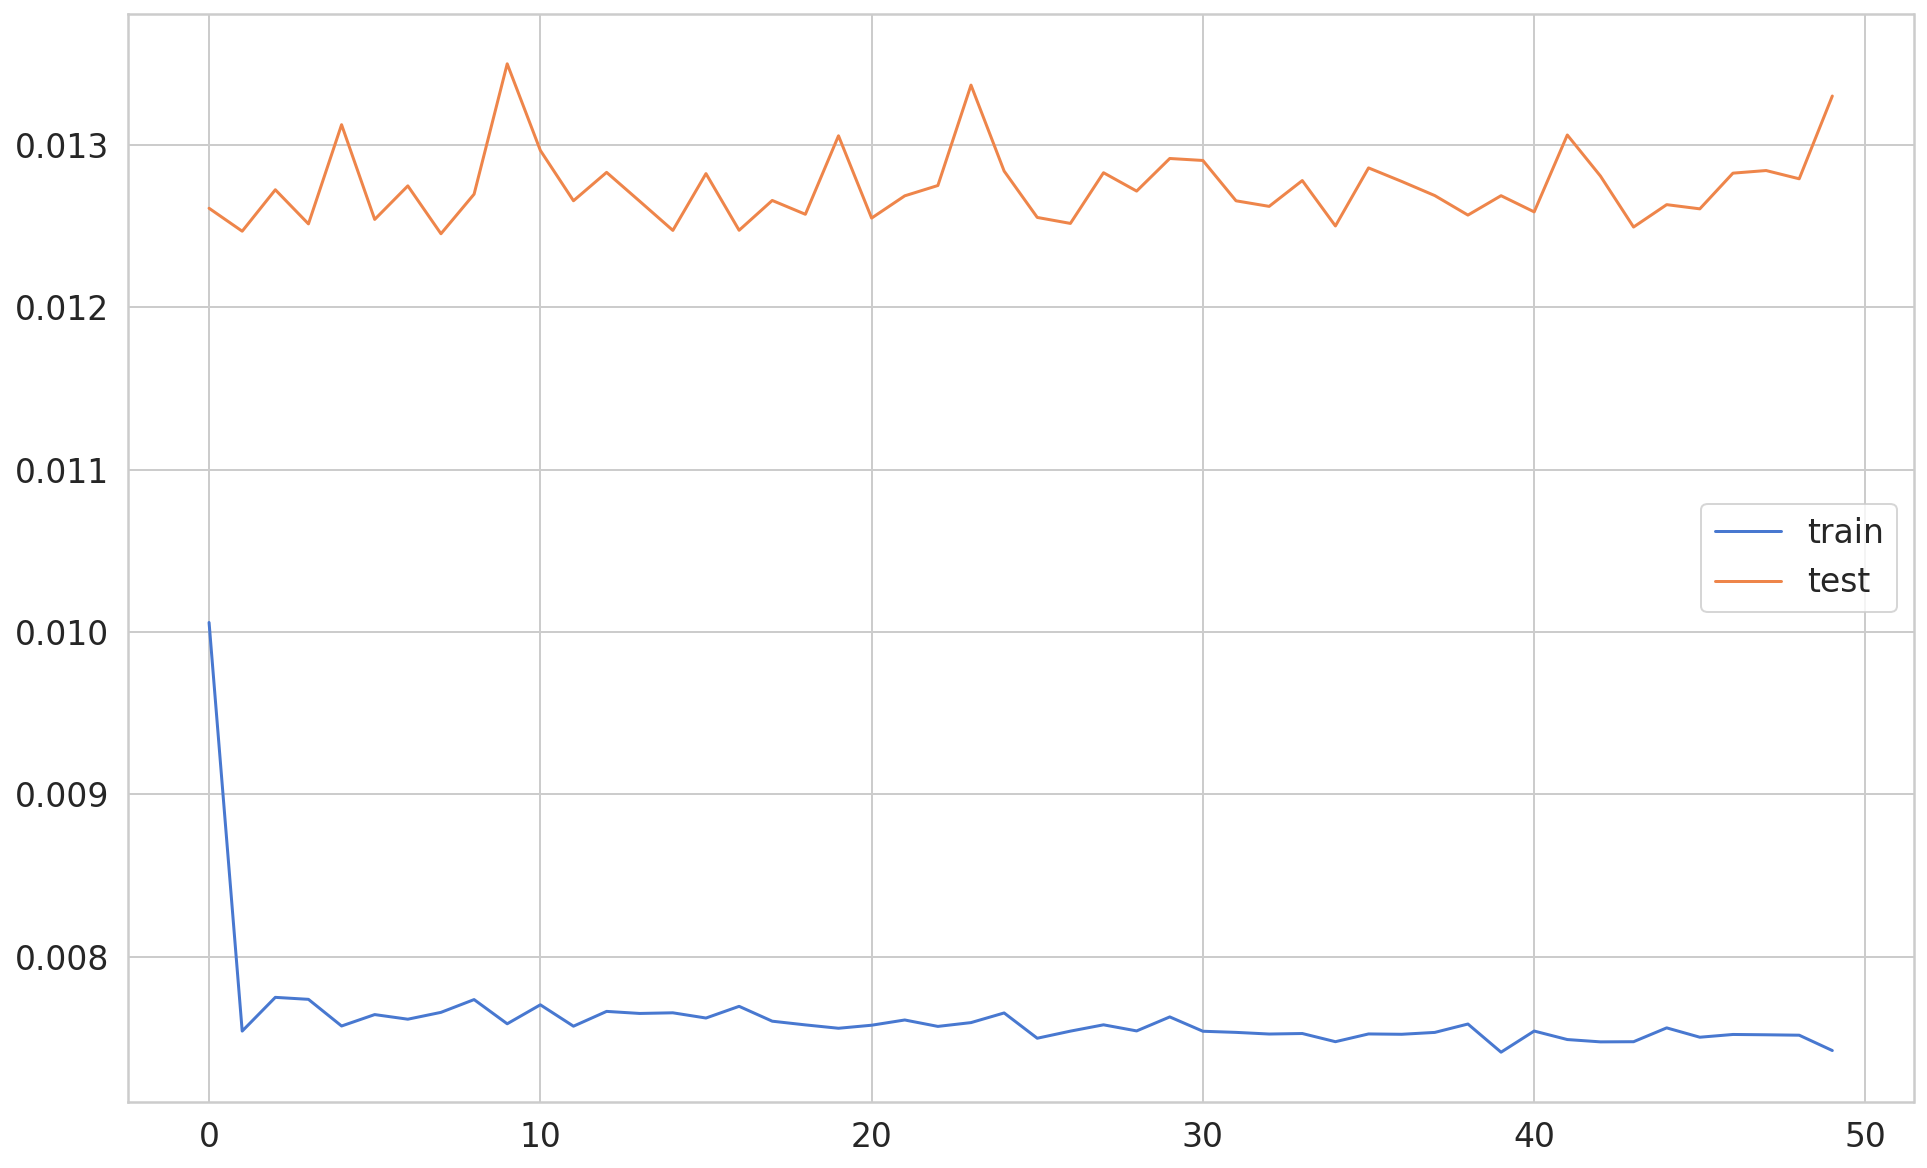

In [90]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [91]:
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)

y_test = np.reshape(y_test, (y_test.shape[0], 1))
y_test.shape

y_train = np.reshape(y_train, (y_train.shape[0], 1))
y_train.shape

y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

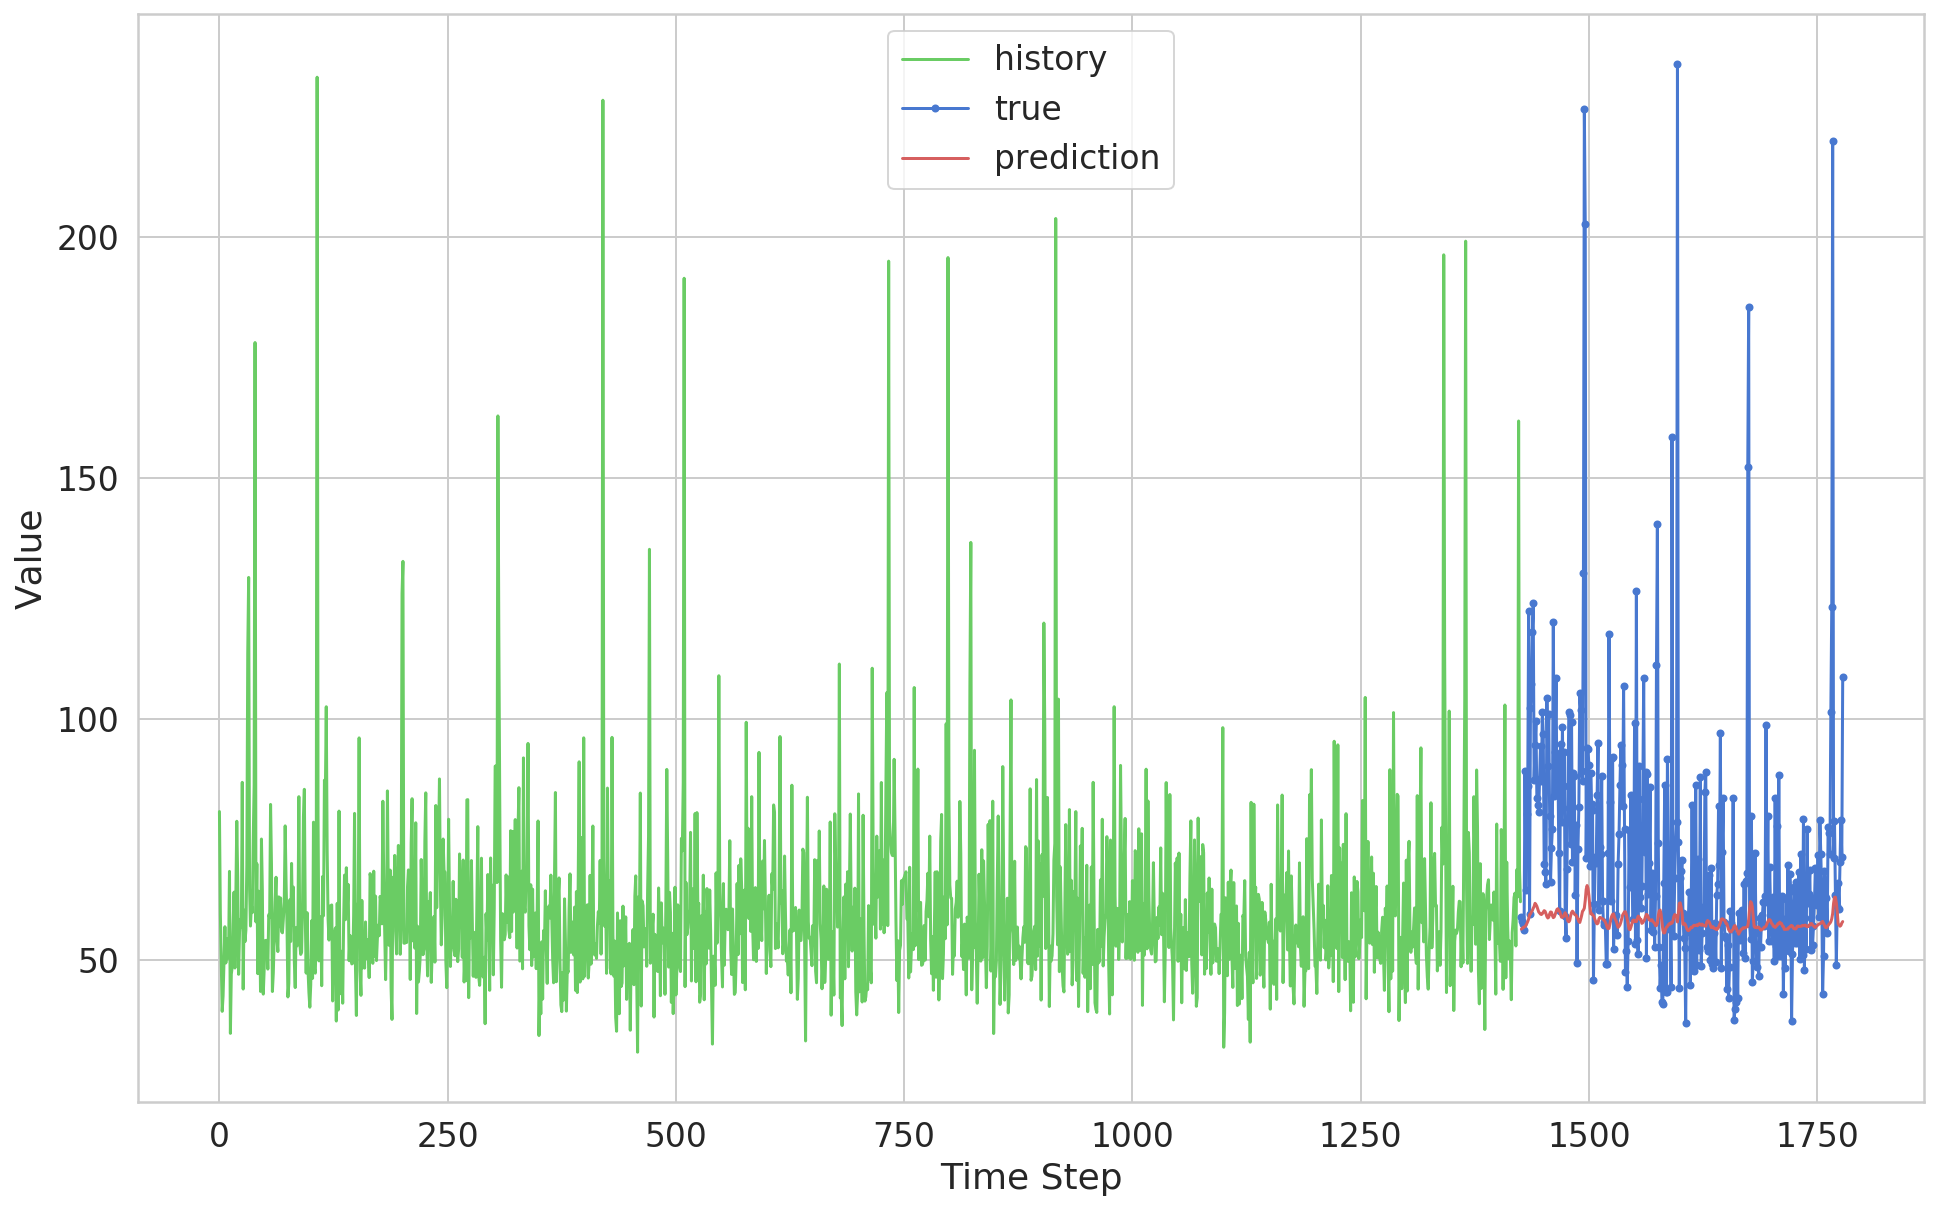

In [92]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

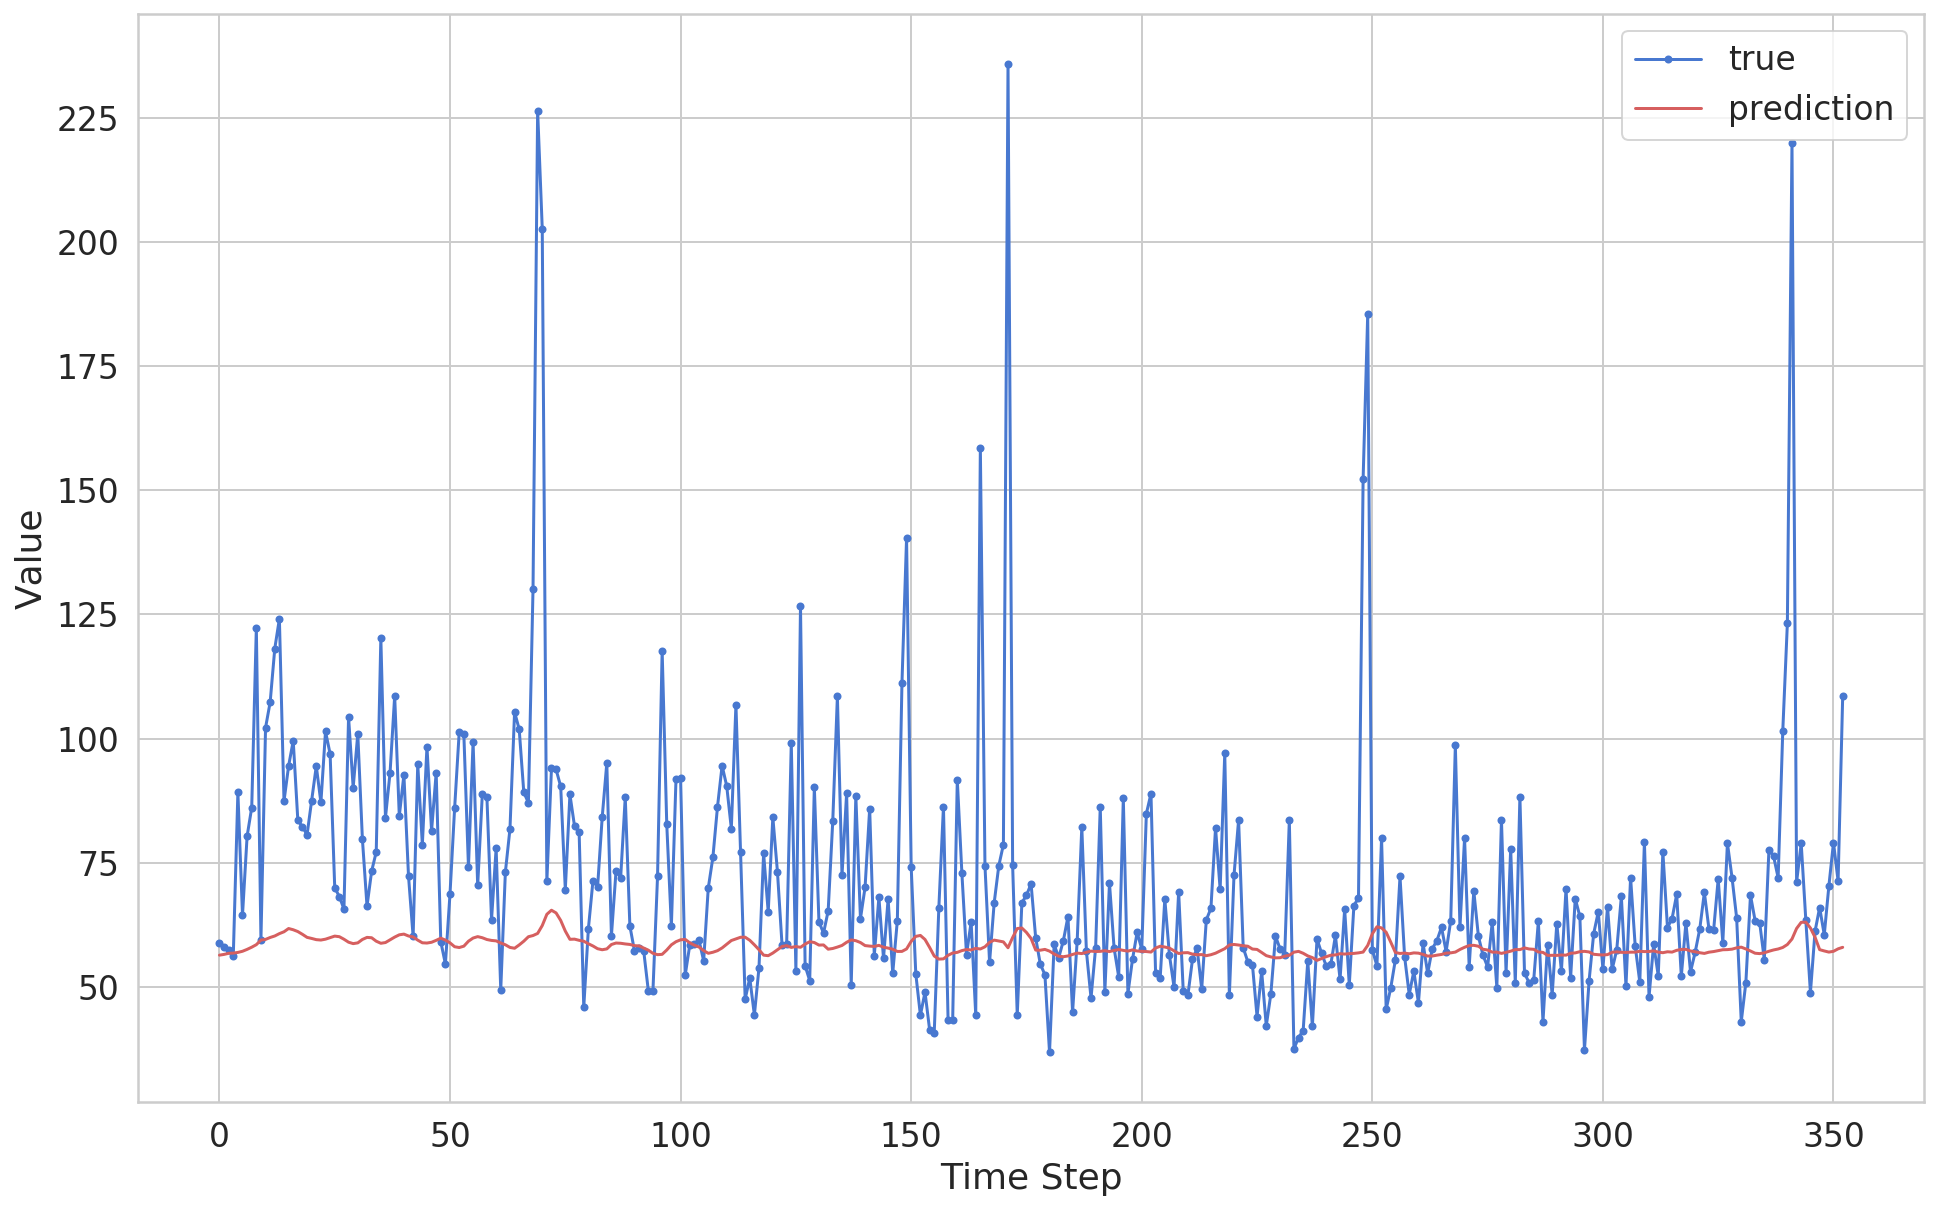

In [93]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

# Save and Load Model

In [94]:
scores = model.evaluate(X_test, y_test, verbose=0)
# print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# save model and architecture to single file
model.save("model.h5")

print(scores)
model.summary()

5778.476219458215
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 5, 50)             10400     
_________________________________________________________________
dropout_12 (Dropout)         (None, 5, 50)             0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 5, 50)             20200     
_________________________________________________________________
dropout_13 (Dropout)         (None, 5, 50)             0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 5, 50)             20200     
_________________________________________________________________
dropout_14 (Dropout)         (None, 5, 50)             0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 

In [95]:
# load and evaluate a saved model
from tensorflow.keras.models import load_model

# load model
model = load_model('model.h5')

# summarize model.
# model.summary()

# load dataset
scores = model.evaluate(X_test, y_test, verbose=0)

print(scores)

5778.476219458215
